In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
sys.path.append('../../')
sys.path.append('../data_processing/')
sys.path.append('../model/')
sys.path.append('../model/utils/')
sys.path.append('../model/EGNN_backbone')

In [3]:
from torch_geometric.loader import DataLoader
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from rdkit import Chem

In [15]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset, CombinedSparseGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

In [5]:
from model.pp_bridge import PPBridge
from model.pp_bridge_sampler import PPBridgeSampler
from model.utils.utils_diffusion import center2zero_combined_graph, center2zero_with_mask, center2zero

In [6]:
config_file = '../../src/lightning_logs/vp_bridge_2024-05-11_00_01_33.009475/vp_bridge.yml'
# config_file = '../../src/config/ve_bridge.yml'
config = OmegaConf.load(config_file)
config

{'model': {'denoiser': {'bridge_type': 'vp', 'beta_d': 2, 'beta_min': 0.1, 'sigma_data': 0.5, 'sigma_max': 1, 'sigma_min': 0.0001, 'schedule_sampler': 'real-uniform', 'use_ema': True, 'ema_decay': 0.999, 'weight_decay': 1e-12, 'weight_schedule': 'uniform', 'loss_x_weight': 1000.0}, 'backbone': {'type': 'EGNN', 'feature_size': 13, 'num_layers': 6, 'hidden_size': 128, 'time_cond': True, 'xT_type': 'pp', 'xT_mode': 'concat_graph'}}, 'training': {'batch_size': 2500, 'log_interval': 100, 'save_interval': 1000, 'test_interval': 1000, 'total_training_steps': 10000000, 'learning_rate': 0.01, 'lr_anneal_steps': 0, 'max_epochs': 100, 'use_lr_scheduler': True, 'lr_scheduler_config': {'target': 'model.utils.lr_scheduler.LambdaLinearScheduler', 'params': {'warm_up_steps': [10000], 'cycle_lengths': [10000000000000], 'f_start': [1e-06], 'f_max': [1.0], 'f_min': [1.0]}}}, 'data': {'root': '../data/cleaned_crossdocked_data', 'max_node_num': 86, 'coord_dim': 3, 'module': 'CombinedSparseGraphDataset'}}

In [7]:
ckpt_path = '../../src/lightning_logs/vp_bridge_2024-05-11_00_01_33.009475/epoch=45-val_loss=2869.17.ckpt'
# ckpt_path = '../../src/lightning_logs/ve_bridge_2024-05-05_23_23_48.007100/epoch=07-val_loss=57275.88.ckpt'
# ckpt = torch.load(ckpt_path)
# ckpt

In [8]:
device = 'cuda:0'

In [12]:
sampler = PPBridgeSampler(config, ckpt_path, device)

Using lr scheduler
config not saved since PPBridgeSampler is not attached to a `Trainer`.
Using real uniform sampler
Using lr scheduler
config not saved since PPBridge is not attached to a `Trainer`.
Using real uniform sampler


In [13]:
for p in sampler.bridge_model.backbone.parameters():
    print(p.name, p.data.device)

None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None cuda:0
None

In [14]:
root = '/data/conghao001/pharmacophore2drug/PP2Drug/data/cleaned_crossdocked_data'
split = 'test'
batch_size = 1
num_workers = 0

In [62]:
# dataset = CombinedGraphDataset(root, split)
dataset = CombinedSparseGraphDataset(root, split)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [63]:
len(dataset)

23291

In [64]:
one = next(iter(dataloader))
one = one.to(device)
one

DataBatch(x=[80, 13], pos=[80, 3], target_x=[80, 13], target_pos=[80, 3], Gt_mask=[80], ligand_name=[1], batch=[80], ptr=[2])

In [65]:
# for batch in dataloader:
#     if batch.ligand_name[0] == '4ls1_A_rec_5h73_7l7_lig_tt_min_0':
#         one = batch
# one = one.to(device)

In [66]:
one.ligand_name

['5q19_C_rec_5q1c_9na_lig_tt_min_0']

In [67]:
# tmp_mask = one.Gt_mask.view(batch_size, -1)
# one.target_x[0][tmp_mask[0]].size()

In [68]:
for node_feat in one.target_x[one.Gt_mask]:
    print(node_feat)

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dev

In [69]:
num_nodes = one.x.size(0)
node_mask = torch.ones([1, num_nodes], device=one.x.device, dtype=torch.bool)

In [70]:
xT, hT, Gt_mask, batch_info = sampler.preprocess(one.target_pos, one.target_x, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, device=device)

In [71]:
xT

tensor([[  1.9372,  -8.8048,  23.5785],
        [  2.4414, -11.1756,  22.6036],
        [  2.4257, -11.1723,  22.6129],
        [  2.4220, -11.1884,  22.5844],
        [  2.6398,  -8.5986,  20.7864],
        [  2.6413,  -8.6027,  20.7457],
        [  2.4357, -11.1916,  22.6017],
        [  2.4526, -11.1733,  22.6109],
        [  2.4273, -11.1805,  22.5838],
        [  2.6424,  -8.6001,  20.7499],
        [  2.6333,  -8.5952,  20.7595],
        [  2.6461,  -5.2858,  22.6898],
        [  2.6501,  -5.2966,  22.6711],
        [  2.6375,  -5.2827,  22.6819],
        [  2.6347,  -5.2877,  22.6875],
        [  2.6471,  -5.2817,  22.6782],
        [  2.6272,  -5.2757,  22.6952],
        [  2.6166,  -8.6021,  20.7655],
        [  2.6245,  -8.5887,  20.7643],
        [  2.6317,  -8.6073,  20.7660],
        [  2.6446,  -8.5770,  20.7515],
        [  2.6159,  -8.6074,  20.7625],
        [  5.1971,  -8.3559,  20.6733],
        [  5.6866,  -9.6583,  21.3095],
        [  2.6332,  -8.6003,  20.7551],


In [72]:
hT

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [73]:
Gt_mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

## Important
***sigma min and max values***
differ for ve/vp bridges!!!

In [74]:
steps = 1000
# x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=one.node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, churn_step_ratio=0.33, device=device)
x, x_traj, h, h_traj, nfe = sampler.sample(one.target_pos, one.target_x, steps, node_mask=node_mask, Gt_mask=one.Gt_mask, batch_info=one.batch, sigma_min=0.001, sigma_max=1, churn_step_ratio=0.33, device=device)

nfe: 2999


In [75]:
print(x.size(), x[Gt_mask].size())

torch.Size([80, 3]) torch.Size([40, 3])


In [76]:
one.batch.size()

torch.Size([80])

In [77]:
num_graphs = max(one.batch).item() + 1
num_graphs

1

In [78]:
i = 0
index_i = one.batch==i
index_i.sum()

tensor(80, device='cuda:0')

In [79]:
# x_i = x[Gt_mask][index_i]
x_i = x[index_i][Gt_mask]
x_i.size()

torch.Size([40, 3])

In [80]:
Gt_mask.device

device(type='cuda', index=0)

In [81]:
x_traj_i = [xt[index_i.cpu()][Gt_mask.cpu()] for xt in x_traj]
x_traj_i

[tensor([[  1.9372,  -8.8048,  23.5785],
         [  2.4414, -11.1756,  22.6036],
         [  2.4257, -11.1723,  22.6129],
         [  2.4220, -11.1884,  22.5844],
         [  2.6398,  -8.5986,  20.7864],
         [  2.6413,  -8.6027,  20.7457],
         [  2.4357, -11.1916,  22.6017],
         [  2.4526, -11.1733,  22.6109],
         [  2.4273, -11.1805,  22.5838],
         [  2.6424,  -8.6001,  20.7499],
         [  2.6333,  -8.5952,  20.7595],
         [  2.6461,  -5.2858,  22.6898],
         [  2.6501,  -5.2966,  22.6711],
         [  2.6375,  -5.2827,  22.6819],
         [  2.6347,  -5.2877,  22.6875],
         [  2.6471,  -5.2817,  22.6782],
         [  2.6272,  -5.2757,  22.6952],
         [  2.6166,  -8.6021,  20.7655],
         [  2.6245,  -8.5887,  20.7643],
         [  2.6317,  -8.6073,  20.7660],
         [  2.6446,  -8.5770,  20.7515],
         [  2.6159,  -8.6074,  20.7625],
         [  5.1971,  -8.3559,  20.6733],
         [  5.6866,  -9.6583,  21.3095],
         [  2.63

In [82]:
x_i

tensor([[ -1.0504, -39.6323,  23.3136],
        [ -2.6128, -34.5455,  30.2798],
        [ -3.9800, -38.3433,  25.2538],
        [ -2.0510, -37.6535,  20.7945],
        [ -4.1127, -39.5672,  21.7675],
        [ -2.3082, -37.5588,  26.4079],
        [ -2.7900, -34.6282,  30.1098],
        [ -5.4567, -41.1300,  22.9050],
        [ -2.9596, -38.0514,  27.3692],
        [ -4.9985, -39.9554,  20.5988],
        [ -4.0625, -38.1997,  26.1590],
        [ -3.7146, -37.9807,  25.9393],
        [ -1.1801, -33.8469,  28.2515],
        [ -0.8505, -33.9681,  27.3132],
        [ -3.7644, -38.1946,  25.5227],
        [ -1.2668, -35.8208,  28.8641],
        [  0.8242, -35.6408,  27.7569],
        [ -4.2615, -37.5666,  24.7357],
        [ -5.0386, -41.8024,  23.6983],
        [ -4.6973, -37.8775,  26.7552],
        [ -5.1057, -41.4864,  22.2460],
        [ -4.4308, -37.8723,  26.2246],
        [ -0.8612, -39.7998,  23.5278],
        [ -0.1077, -35.2848,  28.9665],
        [ -4.4710, -38.7693,  25.7773],


In [83]:
# one.original_pos
original_pos = one.pos[Gt_mask]
original_pos_0center = center2zero(original_pos)
original_pos_0center

tensor([[ -3.6288, -14.3826,  18.0113],
        [ -2.1527, -14.9196,  17.0723],
        [ -2.9660, -15.1198,  18.0858],
        [ -2.2264, -16.6900,  18.9164],
        [ -3.1912, -13.7240,  16.9152],
        [ -2.2851, -14.0313,  16.3165],
        [ -3.0331, -16.0010,  19.0342],
        [ -1.3791, -16.4870,  17.8661],
        [ -1.3339, -15.5916,  16.9255],
        [ -0.6024, -17.1583,  17.7606],
        [ -2.2621, -17.5561,  19.8183],
        [ -3.6348, -12.8129,  16.4478],
        [ -4.4289, -11.7425,  16.1715],
        [ -4.4385, -11.1243,  15.5627],
        [ -3.6702, -12.1801,  15.8502],
        [ -4.7999, -10.9327,  15.7326],
        [ -3.2723, -13.0234,  16.2958],
        [ -4.8305, -10.2790,  15.1096],
        [ -5.3197,  -9.1671,  14.4869],
        [ -4.8526, -11.5156,  16.3683],
        [ -5.2212, -10.4842,  15.7053],
        [ -1.5433, -13.5891,  15.1325],
        [ -0.6305, -14.1940,  14.8246],
        [ -0.0872, -15.4381,  15.5253],
        [  0.7762, -15.9853,  15.2090],


In [84]:
one.pos

tensor([[  2.4039,  -8.3499,  24.0440],
        [  3.1478,  -9.6191,  22.3728],
        [  2.5443,  -9.6095,  23.5961],
        [  2.4615, -12.0021,  23.6043],
        [  2.9293,  -7.6035,  23.0357],
        [  3.3954,  -8.3508,  21.9970],
        [  2.1842, -10.7837,  24.2515],
        [  3.0937, -12.0142,  22.3389],
        [  3.4494, -10.8083,  21.7088],
        [  3.3634, -13.1925,  21.7264],
        [  2.1249, -13.1691,  24.2053],
        [  3.0429,  -6.1352,  23.1255],
        [  2.0413,  -5.2723,  22.6417],
        [  3.3152,  -3.3706,  23.3164],
        [  4.3126,  -4.1973,  23.8330],
        [  2.2099,  -3.9229,  22.7424],
        [  4.1704,  -5.5807,  23.7385],
        [  3.4624,  -1.9861,  23.4025],
        [  2.7481,  -1.0993,  22.5547],
        [  0.8688,  -5.7942,  22.0897],
        [  0.1460,  -5.1170,  21.0725],
        [  4.1747,  -7.8711,  20.8505],
        [  5.6830,  -7.8805,  21.1381],
        [  6.1623,  -9.1886,  21.7748],
        [  7.6534,  -9.1081,  22.0862],


In [85]:
h_i = h[index_i][Gt_mask]
h_i.size()

torch.Size([40, 13])

In [86]:
h_i

tensor([[-2.0071e-01,  1.1841e+00,  1.1608e-02,  9.2898e-02, -5.0204e-02,
         -4.4107e-01,  1.2618e+00, -1.2145e+00,  3.7912e-01, -3.1555e-01,
          2.3235e-01,  3.5420e-01,  1.9667e-01],
        [ 9.1033e-01,  6.7667e-01, -1.5472e-01,  7.5006e-03,  2.2219e-01,
          2.6586e-01, -4.2575e-01,  1.1042e-01,  8.3691e-01,  2.4431e-01,
         -5.7758e-01,  7.5490e-01,  3.4907e-01],
        [-6.5070e-01,  6.1996e-01,  8.3692e-01,  7.5064e-01,  6.9402e-01,
          4.3750e-01, -7.0311e-01,  1.9392e-01,  7.0143e-01, -5.5968e-01,
         -4.3522e-01, -6.3440e-02, -4.0860e-01],
        [ 4.2708e-01,  1.6815e-04,  3.4861e-01,  2.7745e-01, -4.9376e-01,
         -8.1802e-01, -1.8383e-01,  6.0081e-01, -3.8722e-01,  2.5369e-01,
         -7.7026e-01, -6.0821e-02, -2.1405e-01],
        [ 6.2714e-01,  6.6251e-01,  5.9359e-02,  2.6738e-01, -3.8737e-01,
          3.1231e-01,  4.6257e-02,  1.4654e-01,  5.2640e-01, -1.0965e+00,
         -2.1641e-01, -6.2273e-01, -1.2905e-01],
        [-7.397

In [87]:
# torch.argmax(one.x[i], dim=-1)
torch.argmax(one.x, dim=-1)

tensor([3, 1, 1, 1, 1, 3, 1, 1, 1, 7, 7, 1, 1, 1, 1, 3, 1, 5, 1, 5, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 5, 3, 0, 1, 1, 1, 1, 1, 1, 5, 0, 6, 2, 2, 2, 0, 0, 2, 2,
        2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [88]:
# h = F.softmax(h, dim=-1)
h_class = torch.argmax(h_i, dim=-1)
h_class

tensor([ 6,  0,  2,  7,  1,  1,  7,  9,  4,  6,  1,  1,  8,  9,  1,  5,  1,  2,
         1,  1,  9,  7, 12,  1,  1,  9,  1,  1,  0, 12,  1,  1, 11,  1,  4,  1,
         1,  9,  1,  1], device='cuda:0')

In [89]:
h_onehot = torch.nn.functional.one_hot(h_class, num_classes=13)
h_onehot

tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [90]:
atom_index = h_class.detach().cpu()
atom_type = get_atomic_number_from_index(atom_index)
atom_type

[8,
 1,
 6,
 9,
 6,
 6,
 9,
 15,
 7,
 8,
 6,
 6,
 15,
 15,
 6,
 8,
 6,
 6,
 6,
 6,
 15,
 9,
 17,
 6,
 6,
 15,
 6,
 6,
 1,
 17,
 6,
 6,
 16,
 6,
 7,
 6,
 6,
 15,
 6,
 6]

In [91]:
atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic

[True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False]

In [92]:
pos = x_i.detach().cpu().tolist()
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
mol

[02:36:43] WARNING: not removing hydrogen atom without neighbors
[02:36:44] Explicit valence for atom # 21 F, 2, is greater than permitted


MolReconsError: 

In [42]:
mols = []
for i in range(num_graphs):
    index_i = one.batch==i
    x_i = x[Gt_mask][index_i]
    h_i = h[Gt_mask][index_i]
    h_class = torch.argmax(h_i, dim=-1)
    atom_index = h_class.detach().cpu()
    atom_type = get_atomic_number_from_index(atom_index)
    atom_aromatic = is_aromatic_from_index(atom_index)
    pos = x_i.detach().cpu().tolist()
    try:
        mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
        mols.append(mol)
    except:
        continue

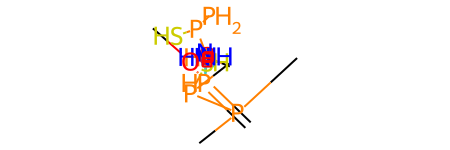

In [43]:
example = mols[0]
example

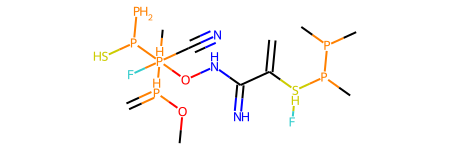

In [44]:
m = Chem.MolFromSmiles(Chem.MolToSmiles(example))
m

In [78]:
with Chem.SDWriter('generated_example.sdf') as w:
  w.write(m)